# Here basically a handmade algorithm for finding lines and trimming them

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
import cv2
import itertools


def set_axis(x, no_labels = 10)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels


In [3]:
path_out = '20240507/'
files = glob.glob(path_out+"*")
files.sort()


In [4]:
dx= 5.106500953873407 
dt= 0.0016
distance_d = dx
time_d = dt


data = []
first_filename = files[0]
# start = files.index('20240507\\092152.npy')
# end = files.index('20240507\\092342.npy')
start = files.index('20240507\\093052.npy')
end = files.index('20240507\\093242.npy')

for file in files[start:end+1]:
   print(f'Loading file: {file}')
   data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')


columns = np.arange(len(data[0])) * dx

print(columns)

df = pd.DataFrame(data=data, index=index, columns=columns)
df.shape

Loading file: 20240507\093052.npy
Loading file: 20240507\093102.npy
Loading file: 20240507\093112.npy
Loading file: 20240507\093122.npy
Loading file: 20240507\093132.npy
Loading file: 20240507\093142.npy
Loading file: 20240507\093152.npy
Loading file: 20240507\093202.npy
Loading file: 20240507\093212.npy
Loading file: 20240507\093222.npy
Loading file: 20240507\093232.npy
Loading file: 20240507\093242.npy
[  0.           5.10650095  10.21300191  15.31950286  20.42600382
  25.53250477  30.63900572  35.74550668  40.85200763  45.95850858
  51.06500954  56.17151049  61.27801145  66.3845124   71.49101335
  76.59751431  81.70401526  86.81051622  91.91701717  97.02351812
 102.13001908 107.23652003 112.34302099 117.44952194 122.55602289
 127.66252385 132.7690248  137.87552575 142.98202671 148.08852766
 153.19502862 158.30152957 163.40803052 168.51453148 173.62103243
 178.72753339 183.83403434 188.94053529 194.04703625 199.1535372
 204.26003815 209.36653911 214.47304006 219.57954102 224.68604197

(75000, 52)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_spectrogram(data, original_df=None, fs=(6,8), no_labels=7):
    if not isinstance(data, pd.DataFrame):
        if original_df is None:
            raise ValueError("If data is not a DataFrame, original_df must be provided for index/columns.")
        data = pd.DataFrame(data=np.abs(data), index=original_df.index, columns=original_df.columns)
    
    fig = plt.figure(figsize=fs)
    ax = plt.axes()

    data -= data.mean()
    data = np.abs(data)
    low, high = np.percentile(data, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    im = ax.imshow(data, interpolation='none', aspect='auto', norm=norm, origin='lower')

    # --- Labeling logic ---
    if isinstance(data.index, pd.DatetimeIndex):
        y_positions, y_labels = set_axis(data.index.time,no_labels)
        ax.set_ylabel("Time")
    else:
        y_positions, y_labels = set_axis(data.index.values,no_labels)
        if "freq" in str(data.index.name).lower():
            ax.set_ylabel("Frequency (Hz)")
        else:
            ax.set_ylabel("Time (s)")
    x_positions, x_labels = set_axis(data.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    ax.set_yticks(y_positions, y_labels)

    plt.xlabel("Channels / Spatial Position")
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)
    plt.show()

    
def visualize_df(df,fs=(4,8)):
    df = np.array(df)
    fig = plt.figure(figsize=fs)
    ax = plt.axes()
    arr = df.copy()
    arr = arr - arr.mean()
    arr = np.abs(arr)
    low, high = np.percentile(arr, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    im = ax.imshow(arr, interpolation='none', aspect='auto', norm=norm, origin='lower')

    plt.show()
    

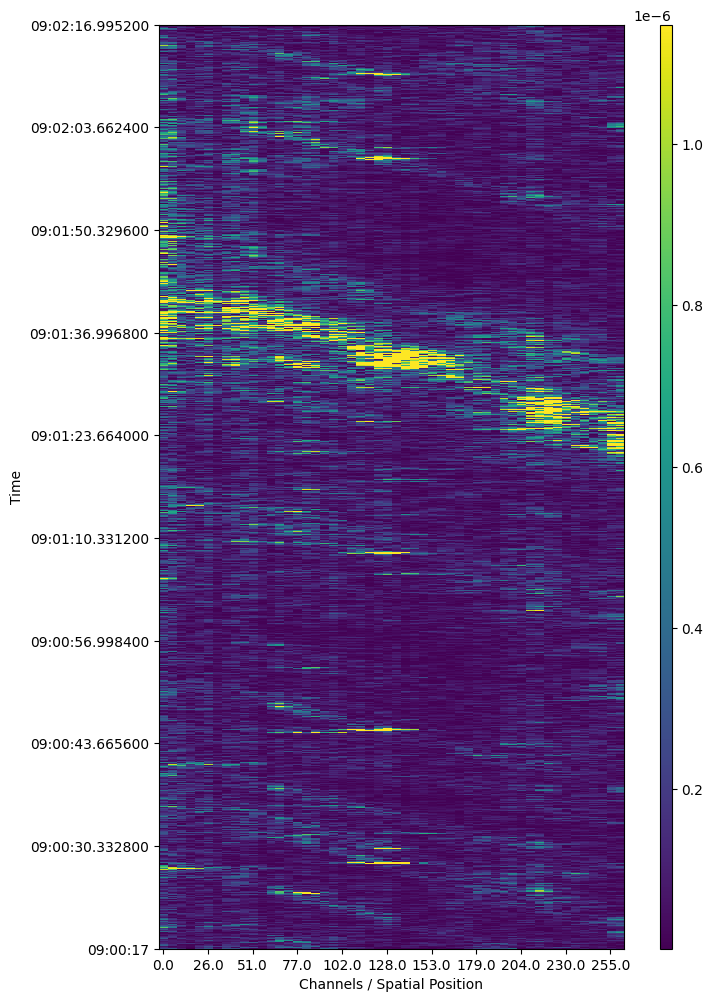

In [6]:
plot_spectrogram(df, fs=(6,12), no_labels=10)

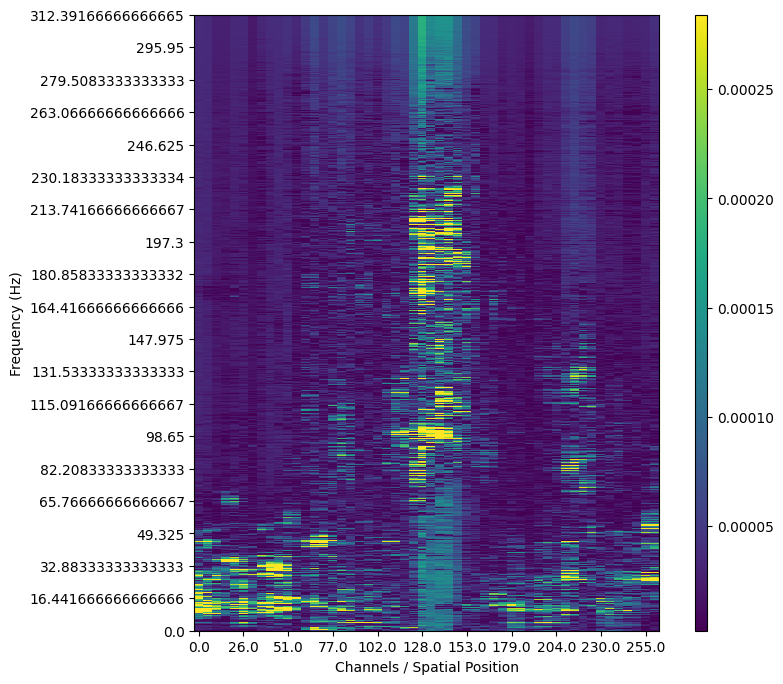

In [7]:
def fft_channels(df, dt):
    reverted = {}
    fft_results = {}

    n = len(df)

    # Only non-negative frequencies (0 ... Nyquist)
    freqs = np.fft.rfftfreq(n, d=dt)

    for channel in df.columns:
        signal = df[channel].values
        
        # Only positive-frequency FFT
        fft_result = np.fft.rfft(signal)

        # Magnitude spectrum
        fft_results[channel] = np.abs(fft_result)

        # Real-valued inverse FFT
        reverted[channel] = np.fft.irfft(fft_result, n=n)

    # Build time index
    if isinstance(df.index, pd.DatetimeIndex):
        time_index = (df.index - df.index[0]).total_seconds()
    else:
        time_index = np.arange(n) * dt

    # DataFrames
    reverted_df = pd.DataFrame(reverted, index=time_index)
    fft_df = pd.DataFrame(fft_results, index=freqs)

    reverted_df.index.name = "Time (s)"
    fft_df.index.name = "Frequency (Hz)"

    return reverted_df, fft_df

reverted_df, fft_df = fft_channels(df, dt)
plot_spectrogram(fft_df, fs=(6,8) ,no_labels=20)


(37501,)


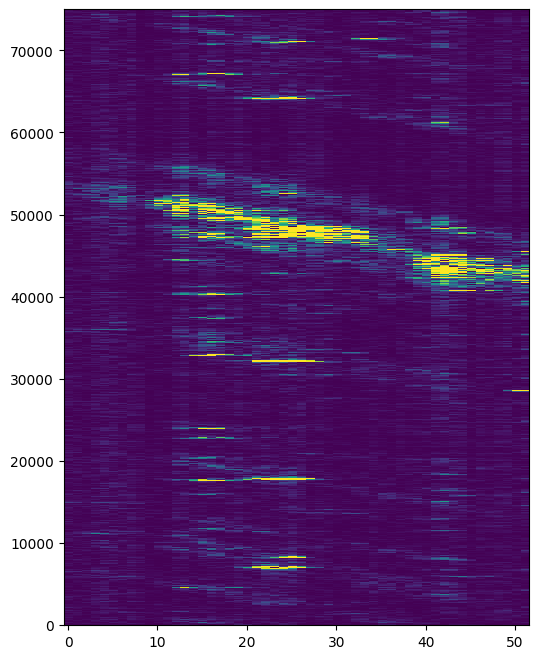

1.4821081e-05 -1.4668693e-05 -2.0188979e-17


In [ ]:
def fft_modify(df, dt,constraints):
    reverted = {}
    fft_results = {}

    n = len(df)
    
    freqs = np.fft.rfftfreq(n, d=dt)
    print(freqs.shape)



    for channel in df.columns:
        signal = df[channel].values
        fft_result = np.fft.rfft(signal)

        remove_mask = np.ones_like(freqs, dtype=bool)
        for constraint in constraints:
            if(channel>=constraint[0] and channel<=constraint[1]):
                freq_range = constraints[constraint]
                remove_mask &= ~((freqs >= freq_range[0]) & (freqs <= freq_range[1]))
                break

        fft_result[remove_mask] = 0

        fft_results[channel] = np.abs(fft_result)

        reverted[channel] = np.fft.irfft(fft_result, n=n)

    if isinstance(df.index, pd.DatetimeIndex):
        time_index = (df.index - df.index[0]).total_seconds()
    else:
        time_index = np.arange(n) * dt

    reverted_df = pd.DataFrame(reverted, index=time_index)
    fft_df = pd.DataFrame(fft_results, index=freqs)

    reverted_df.index.name = "Time (s)"
    fft_df.index.name = "Frequency (Hz)"

    return reverted_df, fft_df


constraints ={ 
    (0,3000): (80,120)
}

reverted_df, fft_df = fft_modify(df, dt, constraints)
visualize_df(np.concatenate([reverted_df], axis=1), fs=(6,8))
print(np.max(reverted_df),np.min(reverted_df),np.mean(reverted_df))


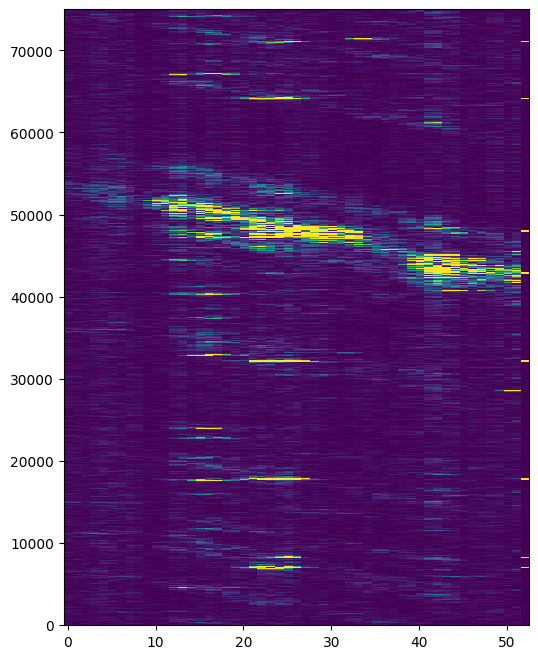

[((25, 6995), 207), ((25, 8201), 153), ((25, 17795), 207), ((25, 32141), 202), ((25, 42826), 25), ((25, 47943), 2303), ((25, 64124), 216), ((25, 71023), 154)]


In [20]:
def detect_vehicles(df, debug=False):
    copy = df.copy()
    
    df_vehicles = pd.DataFrame(copy, index=df.index, columns=df.columns)
    detections_total = np.zeros(df.shape[0], dtype=bool)
    y_pos = [df.columns.get_loc(c) for c in df.columns if c >= 125 and c <= 130][0]
    for c in df.columns:
        if c >= 125 and c <= 130:
            df_vehicles[c] = df[c]
            values = df_vehicles[c].values
            detections = values > values.mean() + 2 * values.std()
            detections_total = detections | detections_total
            
    clusters = []
    for i in range(len(detections_total)):
        if detections_total[i]:
            if len(clusters) == 0 or i - clusters[-1][-1] > 1000:
                clusters.append([i])
            else:
                clusters[-1].append(i)
                
    centers = []
    clusters_row = np.zeros(df.shape[0], dtype=float)
    for cluster in clusters:
        if(len(cluster) < 3):
            continue
        center = int(np.mean(cluster))
        centers.append(((y_pos, center),cluster[-1]-cluster[0]+1))
        clusters_row[center-100:center+100] = 1.0
            
    if debug:
        copy['detections'] = 0.00001 * np.float32(clusters_row)
        visualize_df(copy, fs=(6,8))
    return centers

vehicle_positions = detect_vehicles(reverted_df, debug=True)
print(vehicle_positions)

In [10]:
def bucket_vertically(df, buckets_thickness=15):
    buckets_no = int(df.shape[0] / buckets_thickness)
    bucketed_data = []
    num_rows = df.shape[0]
    bucketed_data = np.zeros((buckets_no, df.shape[1]))
    for i in range(buckets_no):
        start_row = int(i * num_rows / buckets_no)
        end_row = int((i + 1) * num_rows / buckets_no)
        bucketed_data[i, :] = df.iloc[start_row:end_row, :].mean(axis=0)
    return np.array(bucketed_data)

In [11]:
def generate_slopes(intervals = [(1000,10000)], resolution_per_range=100):
    slopes = []
    for interval in intervals:
        for r in range(resolution_per_range+1):
            slopes.append(interval[0] + r * (interval[1] - interval[0]) / resolution_per_range)
    return slopes

In [12]:
def get_score(windows):
    if len(windows) == 0:
        return 0
    return np.sum([np.sum(window) for window in windows]) / (len(windows)+150)

def get_best_cut(windows):
    if len(windows) == 0:
        return None
    max_score = -np.inf
    w = windows[0]
    for window, cut_minus, cut_plus in windows:
        if get_score(window) > max_score:
            max_score = get_score(window)
            w = (window, cut_minus, cut_plus)
    return w


def do_intersect(line1, line2, lengthen=5):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    slope1 = (y2 - y1) / (x2 - x1 + 1e-10)
    slope2 = (y4 - y3) / (x4 - x3 + 1e-10)
    x1, y1, x2, y2 = x1 - lengthen, y1 - slope1*lengthen, x2 + lengthen, y2 + slope1*lengthen
    x3, y3, x4, y4 = x3 - lengthen, y3 - slope2*lengthen, x4 + lengthen, y4 + slope2*lengthen
    
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return False

    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom
    
    

    return 0 <= t <= 1 and 0 <= u <= 1
    

In [13]:
def custom_line_classification(img, positions, resolution, slope_ranges = [(1000,100000),(-100000,-1000)], width_resolution = 3,min_width=5, th_m=1, threshold_line=0.0):
    if type(img) is pd.DataFrame:
        img = img.values
        
    img = np.abs(img)
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    scores = {}
    slopes = generate_slopes(slope_ranges, resolution_per_range=resolution//len(slope_ranges))
    # print(1/slopes[0] * distance_d / time_d * 3.6)
    # print(1/slopes[-1] * distance_d / time_d * 3.6)
    final_lines = []
    positions = sorted(positions, key=lambda x: x[1], reverse=True)
    for i, (position, thickness) in enumerate(positions):
        thickness = int(th_m*thickness)
        lines = []
        x,y = position
        for slope in slopes:
            y_0 = int(y - slope * x)
            do_intersected = False
            for line in final_lines:
                if do_intersect((0, y_0, img.shape[1], y_0 + slope * img.shape[1]),
                                (line[1][0], line[1][1], line[2][0], line[2][1])):
                    do_intersected = True
                    break
            if do_intersected:
                continue
            
            
            windows = []
            for x_i in range(img.shape[1]):
                y_i = int(slope * x_i + y_0)
                if y_i - thickness // 2 >= 0 and y_i + thickness // 2 < img.shape[0]:
                    window = img[y_i - thickness // 2 : y_i + thickness // 2 + 1, x_i]
                    windows.append(window)
                else:
                    windows.append(np.zeros((thickness + 1,)))
            
            
            
            all_windows = []
            for x_0 in range(0,x,width_resolution):
                for x_1 in range(x, img.shape[1], width_resolution):
                    if x_1 - x_0 < min_width:
                        continue
                    window_slice = windows[x_0:x_1]
                    all_windows.append((window_slice, x_0, x_1))
                    
            best_line, cut_minus, cut_plus = get_best_cut(all_windows)
            score = np.sum([np.sum(window) for window in windows]) / (len(windows) * (thickness + 1))
            x_1 = cut_minus
            x_2 = cut_plus
            y_1 = int(slope * x_1 + y_0)
            y_2 = int(slope * x_2 + y_0)
            lines.append((score, (x_1, y_1), (x_2, y_2)))
        
        if lines == []:
            continue
        best_line = max(lines, key=lambda x: x[0])
        # print("Best line for vehicle at position", position, "with thickness", thickness, ":", score)
        # print(np.round((i+1)/len(positions)*100, 2), "%", end='\r')
        if score>threshold_line:
            final_lines.append(best_line)
    return final_lines  

In [14]:
ls = custom_line_classification(reverted_df, vehicle_positions, resolution=100, slope_ranges = [(160,400),(-400,-160)], width_resolution=4,min_width=15, threshold_line = 0.002)

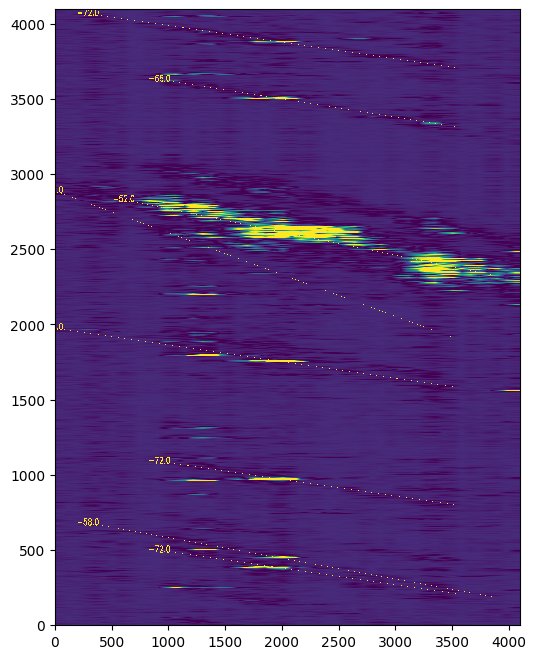

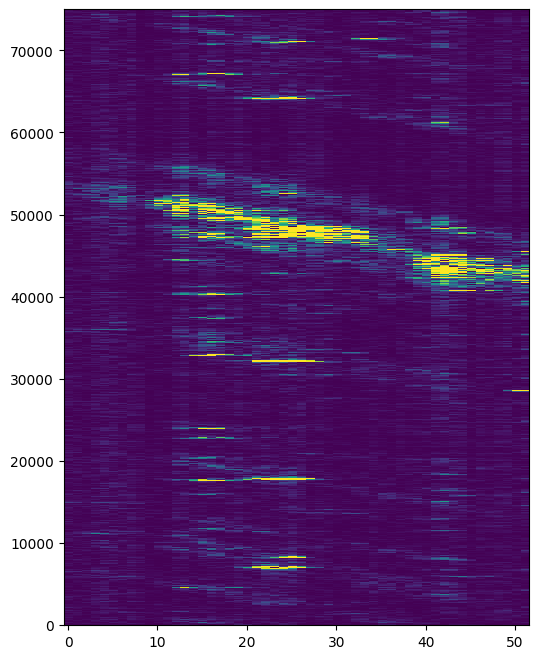

In [15]:
hx = 4096
hy = 4096
dx = reverted_df.shape[1] / hx
dy = reverted_df.shape[0] / hy
final_img = cv2.resize(np.abs(reverted_df.values), (hx, hy), interpolation=cv2.INTER_LINEAR)
final_img = cv2.normalize(final_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
for line in ls:
    score, (x1, y1), (x2, y2) = line
    cv2.line(final_img, (int(x1/dx), int(y1/dy)), (int(x2/dx), int(y2/dy)), int(final_img.max()), 1)
    
    final_img = cv2.flip(final_img, 0)
    speed =np.round((x2 - x1) * distance_d / ((y2 - y1) * time_d) * 3.6)
    cv2.putText(final_img, str(speed), (int(x1/dx)-120, hx-int(y1/dy)+10), cv2.FONT_HERSHEY_SIMPLEX, 2, int(final_img.max()), 5, cv2.LINE_AA)
    final_img = cv2.flip(final_img, 0)
visualize_df(final_img, fs=(6,8))
visualize_df(reverted_df, fs=(6,8))


In [16]:
def task_pipeline(start_name = '20240507\\093052.npy', end_name = '20240507\\093242.npy'):
    dx= 5.106500953873407 
    dt= 0.0016
    distance_d = dx
    time_d = dt


    data = []
    first_filename = files[0]
    start = files.index(start_name)
    end = files.index(end_name)

    for file in files[start:end+1]:
        data.append(np.load(file))
    data = np.concatenate(data)

    time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
    index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')
    columns = np.arange(len(data[0])) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    constraints ={ 
        (0,3000): (80,120)
    }

    reverted_df, fft_df = fft_modify(df, dt, constraints)
    vehicle_positions = detect_vehicles(df)
    ls = custom_line_classification(reverted_df, vehicle_positions, resolution=100, slope_ranges = [(160,400),(-400,-160)], width_resolution=4,min_width=15, threshold_line = 0.002)
    hx = 4096
    hy = 4096
    scale_x = df.shape[1] / hx
    scale_y = df.shape[0] / hy
    final_img = cv2.resize(np.abs(df.values), (hx, hy), interpolation=cv2.INTER_LINEAR)
    final_img = cv2.normalize(final_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    
    # for line in ls:
    #     score, (x1, y1), (x2, y2) = line
    #     cv2.line(final_img, (int(x1/scale_x), int(y1/scale_y)), (int(x2/scale_x), int(y2/scale_y)), int(final_img.max()), 1)
        
    #     final_img = cv2.flip(final_img, 0)
    #     speed =np.round((x2 - x1) * distance_d / ((y2 - y1) * time_d) * 3.6)
    #     cv2.putText(final_img, str(speed), (int(x1/scale_x)-120, hx-int(y1/scale_y)+10), cv2.FONT_HERSHEY_SIMPLEX, 2, int(final_img.max()), 10, cv2.LINE_AA)
    #     final_img = cv2.flip(final_img, 0)
    # visualize_df(final_img, fs=(4,6))
    # visualize_df(reverted_df, fs=(4,6))
    
    fig = plt.figure(figsize=(6,8))
    ax = plt.axes()
    arr = final_img.copy()
    arr = arr - arr.mean()
    arr = np.abs(arr)
    low, high = np.percentile(arr, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)
    for line in ls:
        score, (x1, y1), (x2, y2) = line
        ax.plot([int(x1/scale_x), int(x2/scale_x)], [int(y1/scale_y), int(y2/scale_y)], color='red', linewidth=1)
        xm, ym = (int(x1/scale_x), int(y1/scale_y))
        ax.text(xm-120, ym+10, str(np.round((x2 - x1) * distance_d / ((y2 - y1) * time_d) * 3.6, 2)), fontsize=12, color='red')
    ax.axis('off')
    im = ax.imshow(arr, interpolation='none', aspect='auto', norm=norm, origin='lower')
    visualize_df(reverted_df, fs=(4,6))

(37501,)


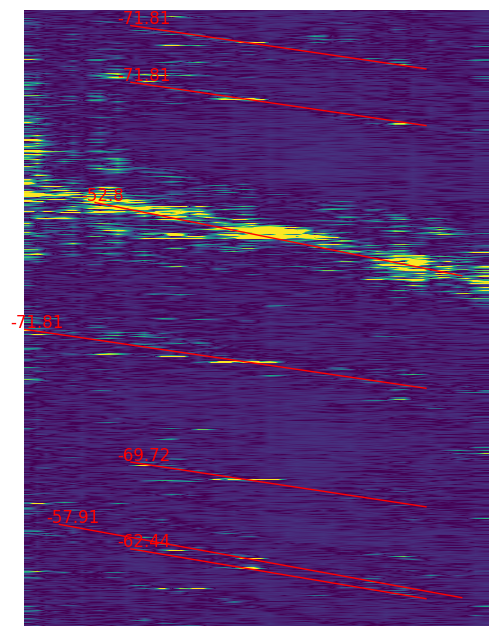

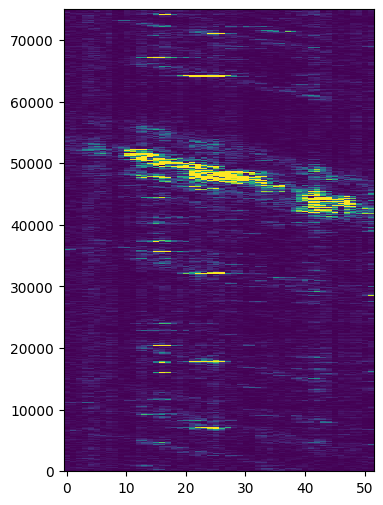

In [17]:
task_pipeline('20240507\\093052.npy', '20240507\\093242.npy')

(37501,)


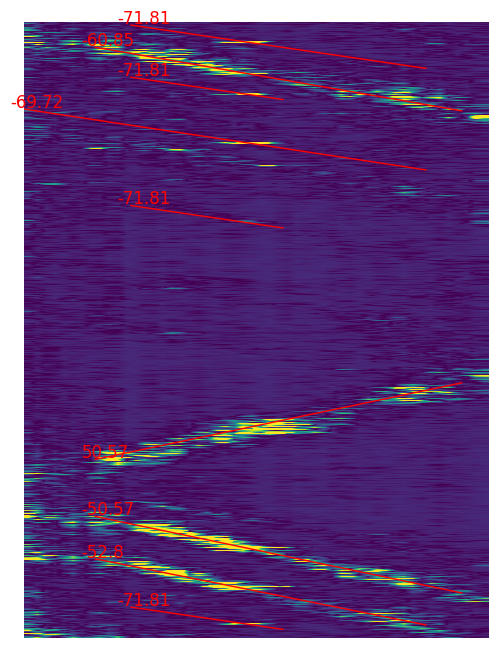

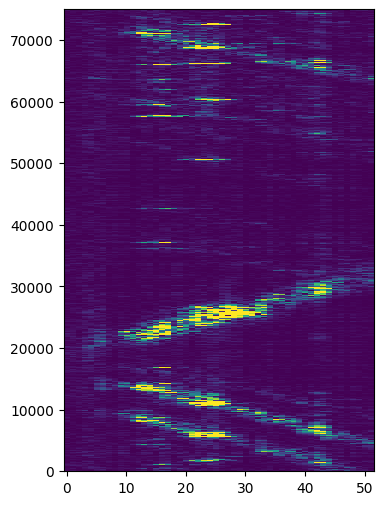

In [18]:
task_pipeline('20240507\\092152.npy', '20240507\\092342.npy')

(37501,)


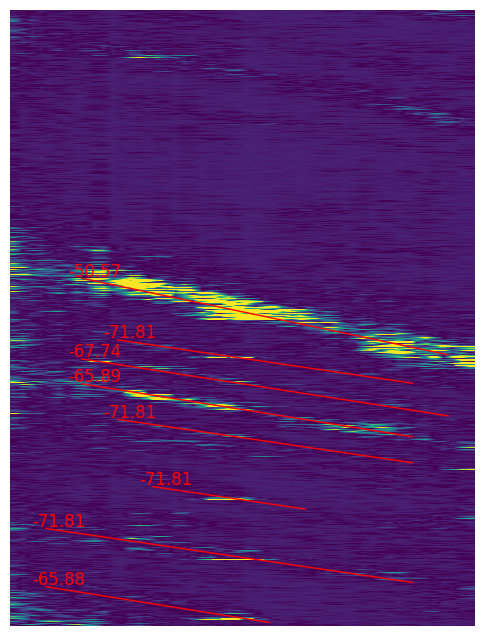

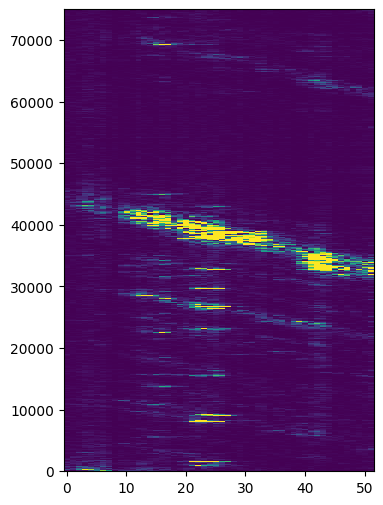

In [19]:
task_pipeline('20240507\\091722.npy', '20240507\\091912.npy')